In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from statsmodels.tsa.seasonal import STL

In [2]:
#Load Data
dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_24764\3189321535.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')


In [3]:
# Define function to get financial year
def get_financial_year(date):
    if pd.isna(date):
        return np.nan
    return date.year if date.month >= 4 else date.year - 1

# --- ensure dates are in datetime ---
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

dataset['registration_year'] = dataset['date_of_registration'].dt.to_period('Y')
dataset['removal_year'] = dataset['date_of_removal'].dt.to_period('Y')

dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')

dataset['registration_fy'] = dataset['date_of_registration'].apply(get_financial_year)
dataset['removal_fy'] = dataset['date_of_removal'].apply(get_financial_year)

In [4]:
# Step 1: Drop rows with missing classification
classification_df = dataset[['registered_charity_number', 'classification_description']].dropna()

# Step 2: Create binary indicator (1) for each classification
classification_df['value'] = 1

# Step 3: Pivot to wide format with binary columns
classification_dummies = classification_df.pivot_table(
    index='registered_charity_number',
    columns='classification_description',
    values='value',
    aggfunc='max',
    fill_value=0
)

# Step 4: Optional – rename columns for consistency (e.g., no spaces or special chars)
classification_dummies.columns = [
    f"classification_{str(col).replace(' ', '_').replace('-', '_').lower()}"
    for col in classification_dummies.columns
]

# Step 5: Reset index and merge with original dataset
classification_dummies = classification_dummies.reset_index()
dataset = dataset.drop_duplicates(subset='registered_charity_number')  # ensure one row per charity
dataset = dataset.merge(classification_dummies, on='registered_charity_number', how='left')

# Identify classification dummy columns (typically start with 'classification_')
category_cols = [col for col in dataset.columns if col.startswith('classification_')]

# Fill NaNs with 0 in those columns only
dataset[category_cols] = dataset[category_cols].fillna(0)


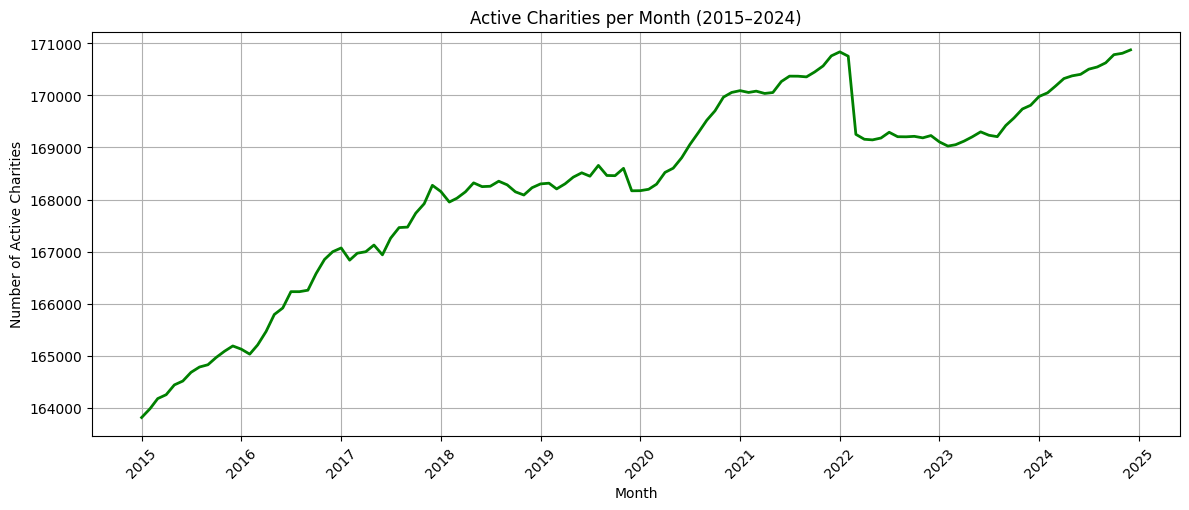

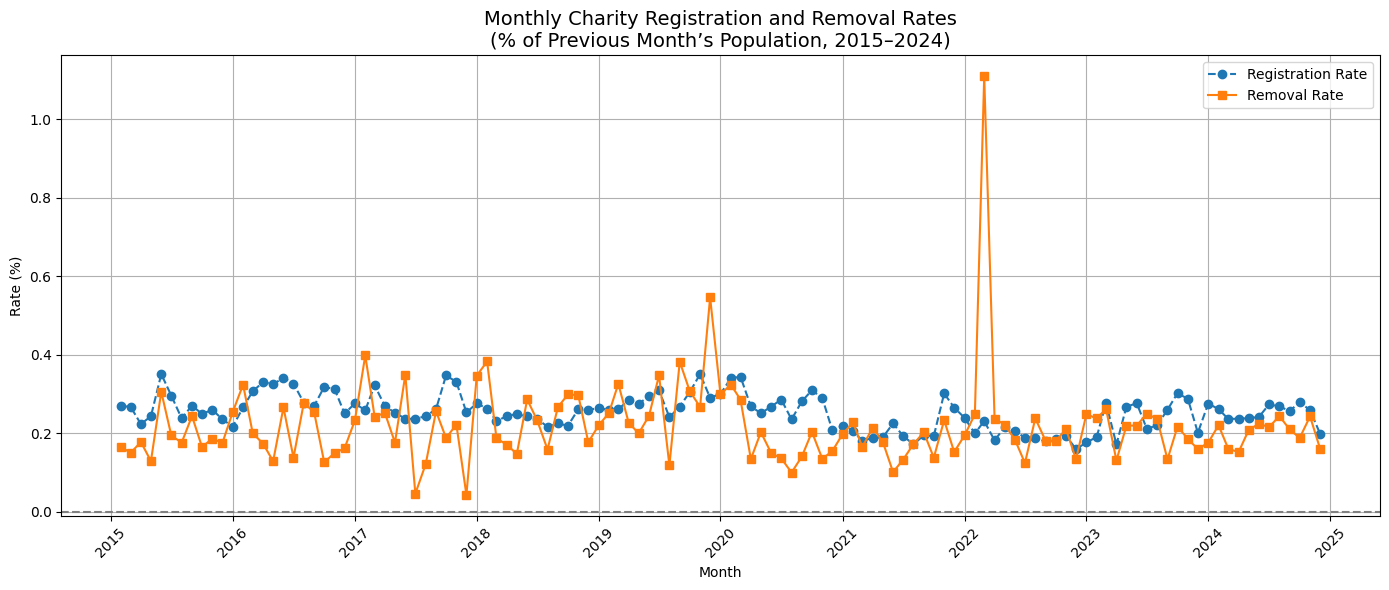

In [5]:
# --- Step 1: Prepare datetime columns ---
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')

# Ensure Period (monthly) format for registration/removal
dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')

# --- Step 2: Build full monthly period range ---
all_months = pd.period_range(start='2015-01', end='2024-12', freq='M')

# --- Step 3: Calculate active charities at each month-end ---
population_by_month = []
for month in all_months:
    active = dataset[
        (dataset['registration_month'] <= month) &
        ((dataset['removal_month'].isna()) | (dataset['removal_month'] > month))
    ]
    population_by_month.append({'month': month, 'active': len(active)})

population_df = pd.DataFrame(population_by_month).set_index('month')

# --- Step 4: Count registrations and removals per month ---
registered = dataset['registration_month'].value_counts().sort_index()
removed = dataset['removal_month'].value_counts().sort_index()

# Ensure full alignment with all months
registered = registered.reindex(all_months, fill_value=0)
removed = removed.reindex(all_months, fill_value=0)

# --- Step 5: Compute rates ---
population_df['prev_population'] = population_df['active'].shift(1)
population_df['registered'] = registered
population_df['removed'] = removed
population_df['registration_rate'] = (population_df['registered'] / population_df['prev_population']) * 100
population_df['removal_rate'] = (population_df['removed'] / population_df['prev_population']) * 100

# --- Step 6:  Plot active charities ---
plt.figure(figsize=(12, 5))
plt.plot(population_df.index.to_timestamp(), population_df['active'], linewidth=2, color='green')
plt.title('Active Charities per Month (2015–2024)')
plt.xlabel('Month')
plt.ylabel('Number of Active Charities')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# --- Step 7: Plot registration/removal rates ---
plt.figure(figsize=(14, 6))
plt.plot(population_df.index.to_timestamp(), population_df['registration_rate'], marker='o', linestyle='--', label='Registration Rate')
plt.plot(population_df.index.to_timestamp(), population_df['removal_rate'], marker='s', linestyle='-', label='Removal Rate')
plt.title('Monthly Charity Registration and Removal Rates\n(% of Previous Month’s Population, 2015–2024)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

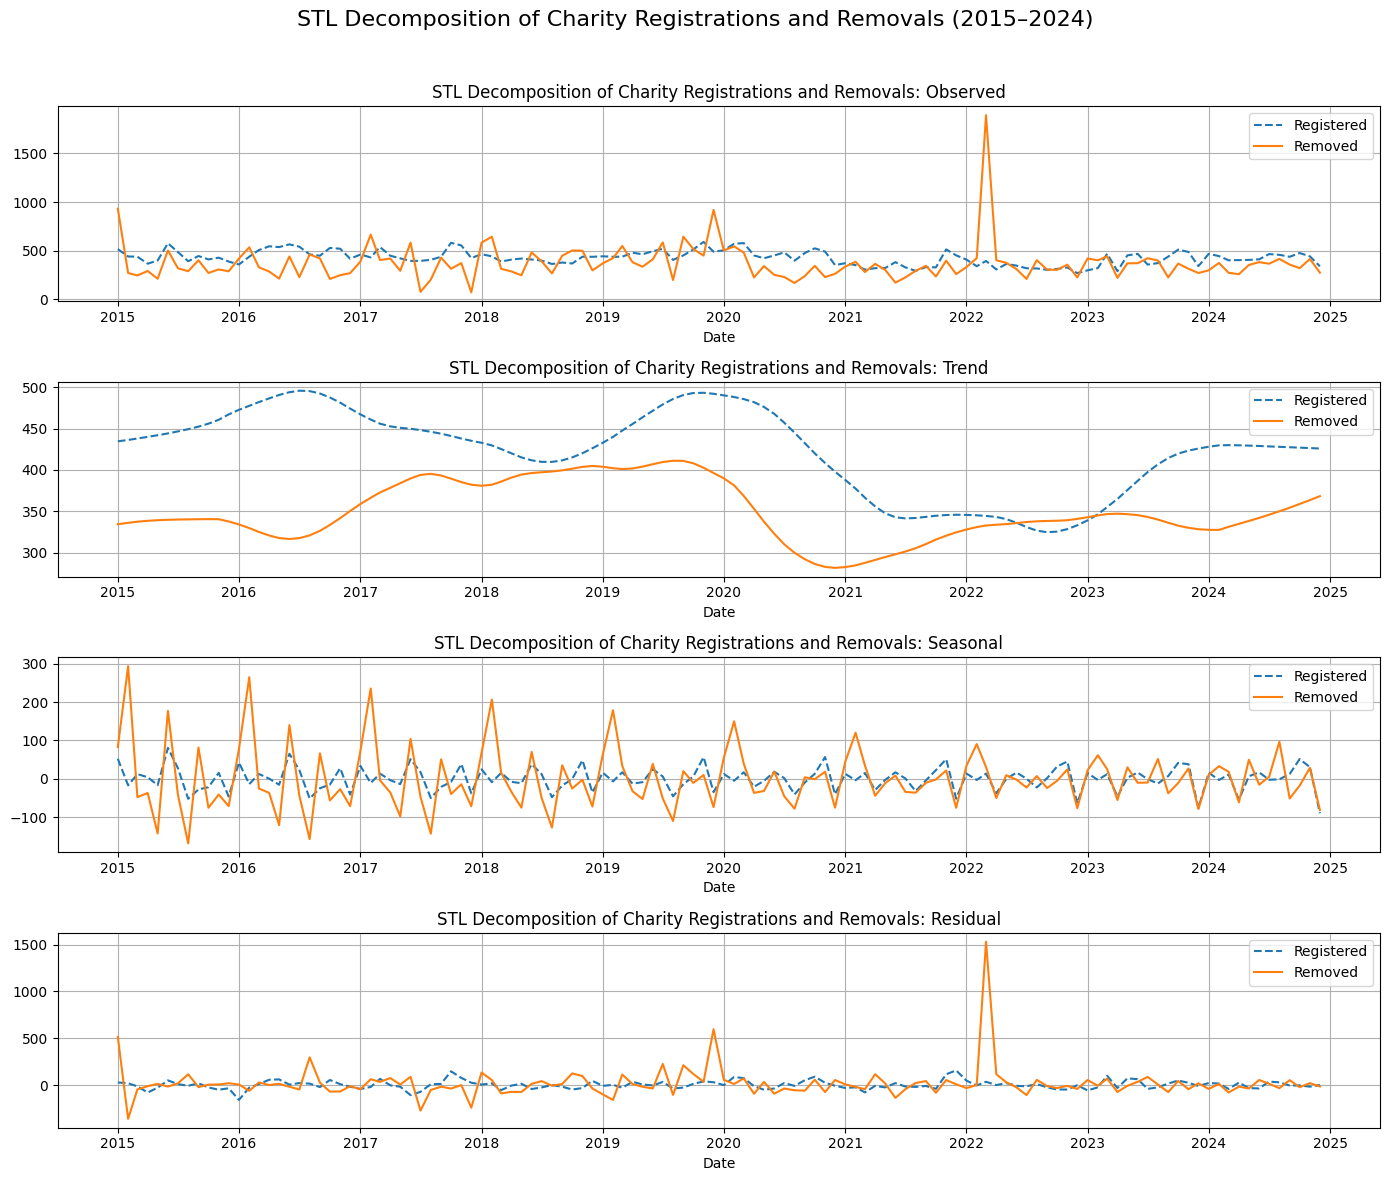

In [6]:
# --- Step 1: Define full monthly range ---
monthly_index = pd.date_range(start='2015-01-01', end='2024-12-01', freq='MS')

# --- Step 2: Aggregate registrations and removals to monthly counts ---
def count_monthly(series, monthly_index):
    return (
        series.value_counts()
        .sort_index()
        .reindex(monthly_index.to_period('M'), fill_value=0)
        .to_timestamp()
    )

registered_by_month = count_monthly(dataset['registration_month'], monthly_index)
removed_by_month = count_monthly(dataset['removal_month'], monthly_index)

# --- Step 3: STL decomposition ---
def apply_stl(series, period=13):
    return STL(series, seasonal=period, robust=True).fit()

stl_reg = apply_stl(registered_by_month)
stl_rem = apply_stl(removed_by_month)

# --- Step 4: Plot each component as a separate graph ---
components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Observed', 'Trend', 'Seasonal', 'Residual']
colors = {'Registered': '#1f77b4', 'Removed': '#ff7f0e'}

fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=False)  # sharex=False ensures each has full x-axis

for i, comp in enumerate(components):
    axs[i].plot(getattr(stl_reg, comp), label='Registered', color=colors['Registered'], linestyle='--')
    axs[i].plot(getattr(stl_rem, comp), label='Removed', color=colors['Removed'], linestyle='-')
    axs[i].set_title(f'STL Decomposition of Charity Registrations and Removals: {titles[i]}')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlabel('Date')  # Ensure x-axis label is shown

plt.suptitle('STL Decomposition of Charity Registrations and Removals (2015–2024)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


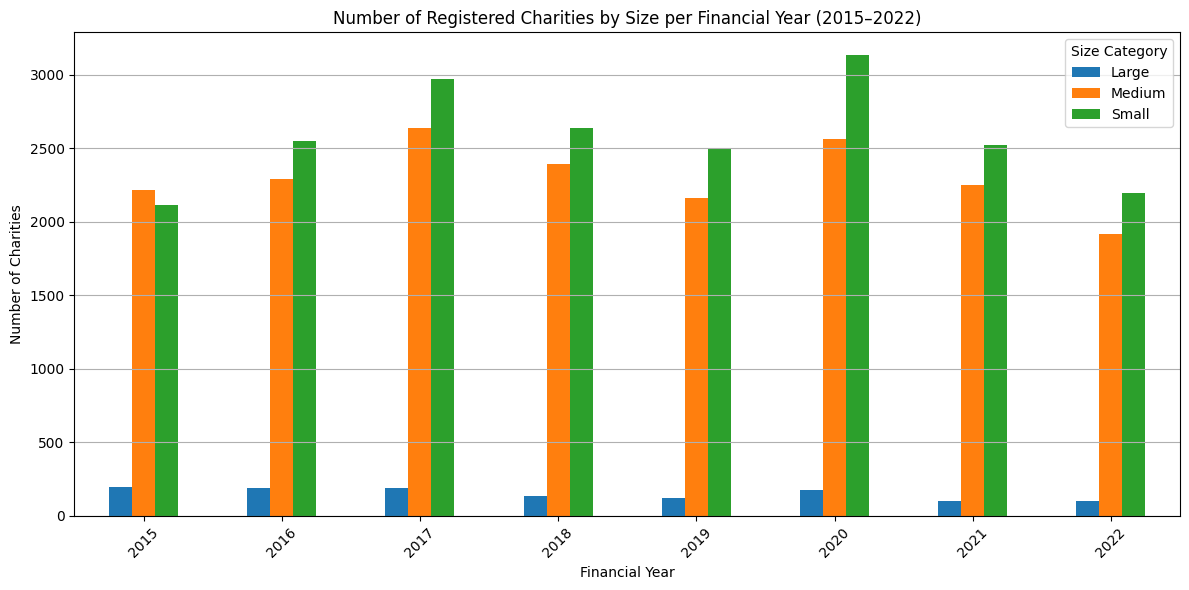

In [7]:
# Extract financial year from registration date (FY starts in April)
dataset['registration_fy'] = dataset['date_of_registration'].apply(
    lambda x: x.year if x.month < 4 else x.year + 1
)

# Filter to years 2015–2022
fy_counts = (
    dataset[dataset['registration_fy'].between(2015, 2022)]
    .groupby(['registration_fy', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

# Plot
ax = fy_counts.plot(kind='bar', figsize=(12, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Number of Registered Charities by Size per Financial Year (2015–2022)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Charities')
plt.xticks(rotation=45)
plt.legend(title='Size Category')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

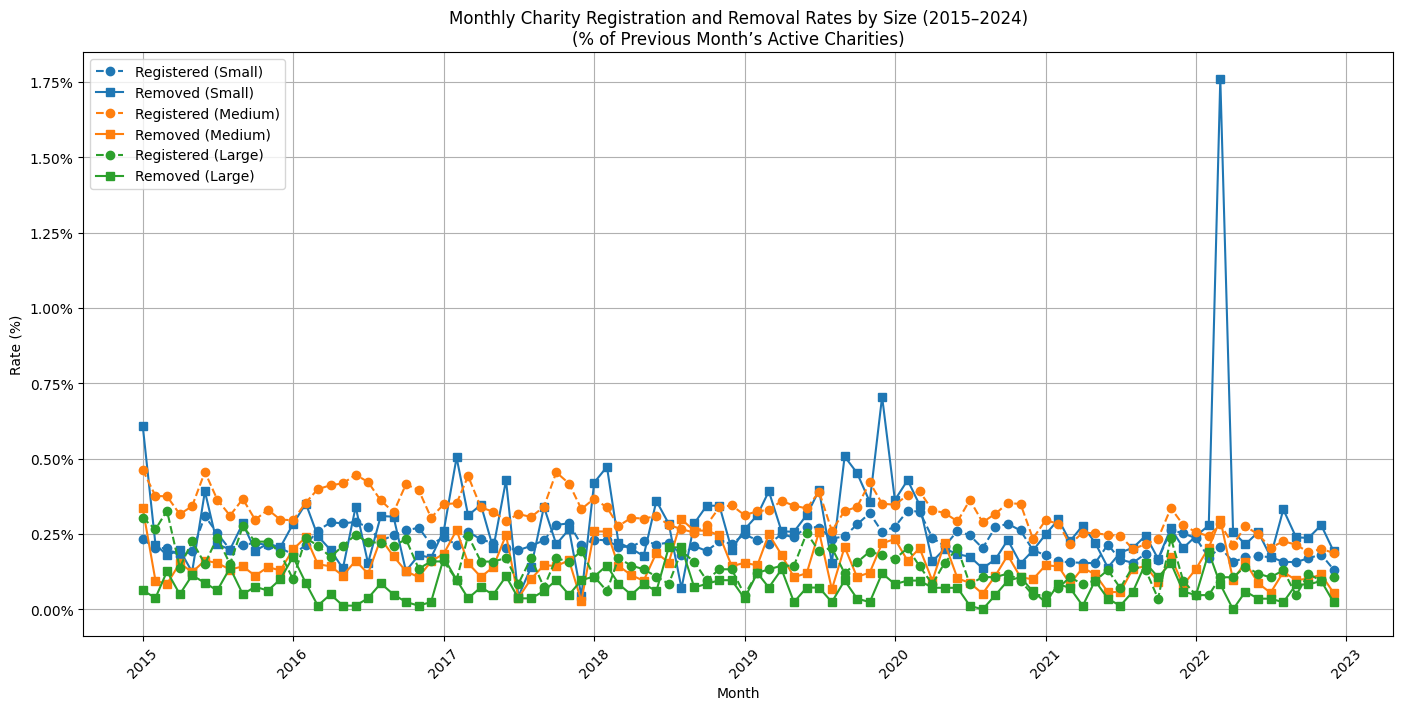

In [8]:
# Define monthly period range
all_months = pd.period_range(start='2014-12', end='2022-12', freq='M')

# Ensure datetime columns and period columns exist
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'], errors='coerce')
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'], errors='coerce')
dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')

# Calculate registration and removal counts by size and month
registered_counts = (
    dataset[dataset['registration_month'].between('2015-01', '2024-12')]
    .groupby(['registration_month', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

removed_counts = (
    dataset[dataset['removal_month'].between('2015-01', '2024-12')]
    .groupby(['removal_month', 'size_category'])
    .size()
    .unstack(fill_value=0)
)

# Calculate population at the start of each month
monthly_population = {}
for month in all_months[1:]:  # Start from 2015-01
    active = dataset[
        (dataset['registration_month'] <= month - 1) &
        ((dataset['removal_month'].isna()) | (dataset['removal_month'] > month - 1))
    ]
    counts = active['size_category'].value_counts().to_dict()
    monthly_population[month] = counts

population_df = pd.DataFrame(monthly_population).T.fillna(0).astype(int)
population_df.index.name = 'month'

# Calculate percentage
reg_pct = (registered_counts.div(population_df) * 100).dropna()
rem_pct = (removed_counts.div(population_df) * 100).dropna()

# Convert index for plotting
reg_pct.index = reg_pct.index.to_timestamp()
rem_pct.index = rem_pct.index.to_timestamp()

# Plotting
plt.figure(figsize=(14, 7))
colors = {'Small': 'tab:blue', 'Medium': 'tab:orange', 'Large': 'tab:green'}

for size in ['Small', 'Medium', 'Large']:
    if size in reg_pct.columns:
        plt.plot(reg_pct.index, reg_pct[size], linestyle='--', marker='o', color=colors[size], label=f'Registered ({size})')
    if size in rem_pct.columns:
        plt.plot(rem_pct.index, rem_pct[size], linestyle='-', marker='s', color=colors[size], label=f'Removed ({size})')

plt.title('Monthly Charity Registration and Removal Rates by Size (2015–2024)\n(% of Previous Month’s Active Charities)')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_24764\2199672018.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby(['removal_fy', 'removal_age_group'])


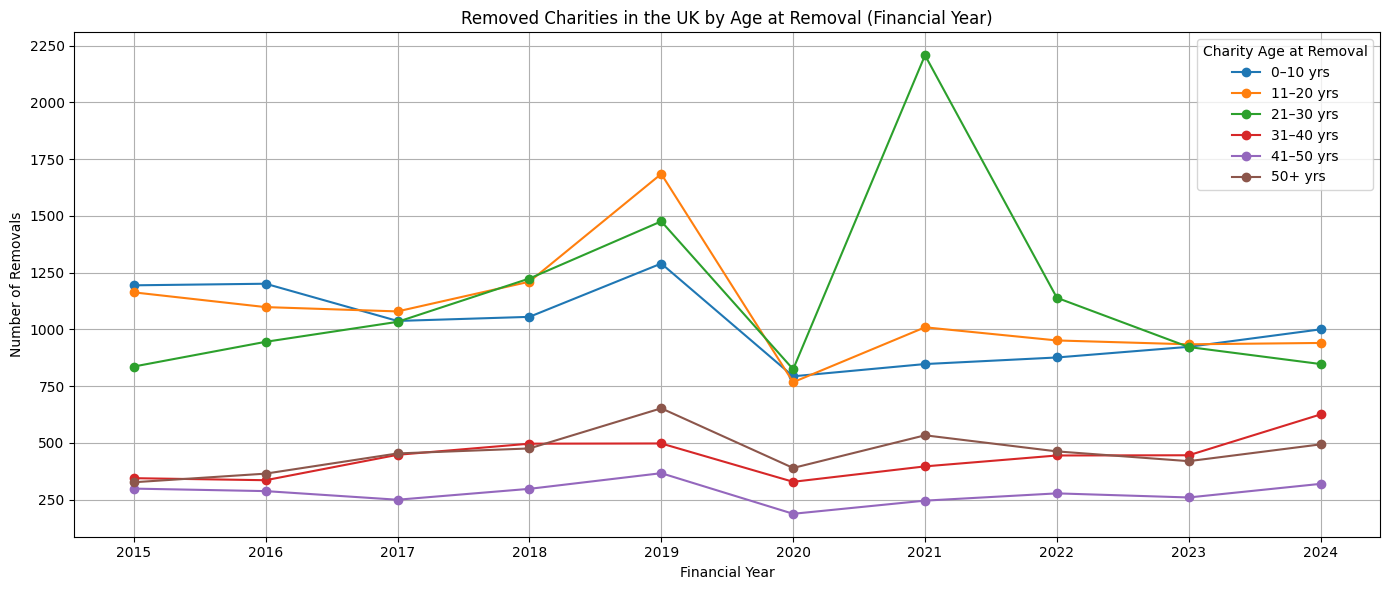

In [9]:
# --- Calculate charity age at removal ---
dataset['age_at_removal'] = (
    dataset['date_of_removal'] - dataset['date_of_registration']
).dt.days // 365  # convert to approximate years

# --- Define age bins and labels ---
bins = [0, 10, 20, 30, 40, 50, float('inf')]
labels = ['0–10 yrs', '11–20 yrs', '21–30 yrs', '31–40 yrs', '41–50 yrs', '50+ yrs']
dataset['removal_age_group'] = pd.cut(dataset['age_at_removal'], bins=bins, labels=labels, right=False)

# --- Filter data to financial years of interest ---
filtered = dataset[dataset['removal_fy'].between(2015, 2024)]

# --- Group and count removals by FY and age group ---
removals_by_age_fy = (
    filtered.groupby(['removal_fy', 'removal_age_group'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# --- Plot ---
plt.figure(figsize=(14, 6))
for col in removals_by_age_fy.columns:
    plt.plot(removals_by_age_fy.index, removals_by_age_fy[col], marker='o', label=col)

plt.title('Removed Charities in the UK by Age at Removal (Financial Year)')
plt.xlabel('Financial Year')
plt.ylabel('Number of Removals')
plt.legend(title='Charity Age at Removal')
plt.grid(True)
plt.tight_layout()
plt.xticks(removals_by_age_fy.index)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_24764\456935641.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby(['removal_fy', 'size_category', 'removal_age_group'])
C:\Users\User\AppData\Local\Temp\ipykernel_24764\456935641.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  grouped.pivot_table(index='removal_fy', columns=['size_category', 'removal_age_group'], values='count', fill_value=0)


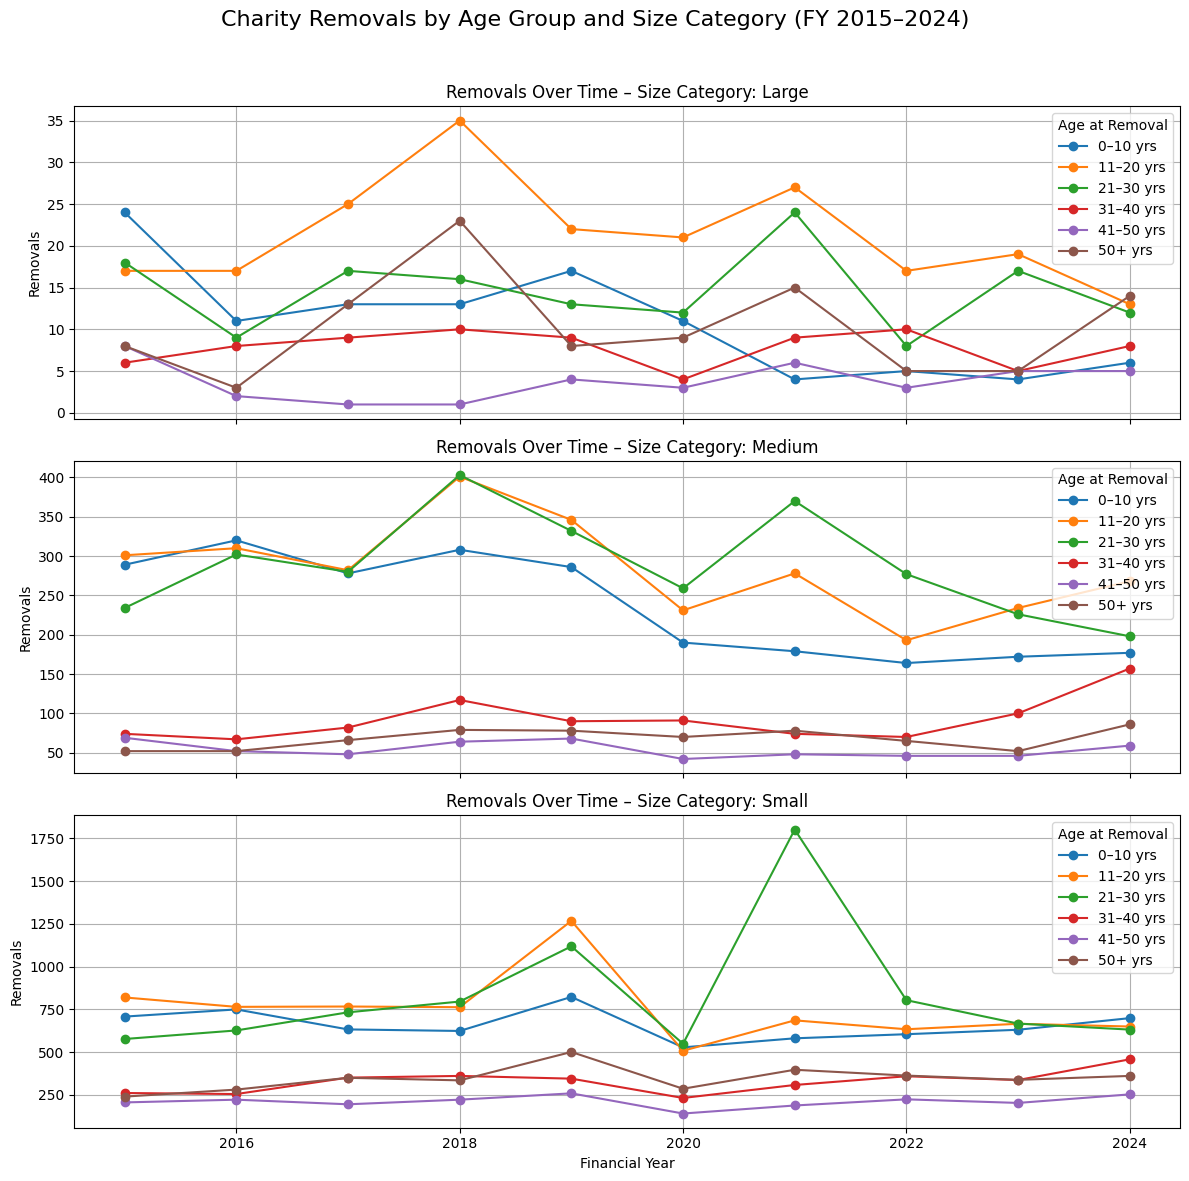

In [10]:
# --- Step 2: Bin age into groups ---
bins = [0, 10, 20, 30, 40, 50, float('inf')]
labels = ['0–10 yrs', '11–20 yrs', '21–30 yrs', '31–40 yrs', '41–50 yrs', '50+ yrs']
dataset['removal_age_group'] = pd.cut(dataset['age_at_removal'], bins=bins, labels=labels, right=False)

# --- Step 3: Filter to valid data ---
filtered = dataset[
    dataset['removal_fy'].between(2015, 2024) &
    dataset['removal_age_group'].notna() &
    dataset['size_category'].notna()
]

# --- Step 4: Group and pivot ---
grouped = (
    filtered.groupby(['removal_fy', 'size_category', 'removal_age_group'])
    .size()
    .reset_index(name='count')
)

pivoted = (
    grouped.pivot_table(index='removal_fy', columns=['size_category', 'removal_age_group'], values='count', fill_value=0)
)

# --- Step 5: Plot (one subplot per size category) ---
size_categories = pivoted.columns.get_level_values(0).unique()
age_groups = labels

fig, axs = plt.subplots(len(size_categories), 1, figsize=(12, 4 * len(size_categories)), sharex=True)

if len(size_categories) == 1:
    axs = [axs]  # make iterable if only one category

for i, size in enumerate(size_categories):
    ax = axs[i]
    for age in age_groups:
        try:
            ax.plot(pivoted.index, pivoted[size, age], marker='o', label=age)
        except KeyError:
            continue  # some age groups might be missing in smaller samples
    ax.set_title(f'Removals Over Time – Size Category: {size}')
    ax.set_ylabel('Removals')
    ax.legend(title='Age at Removal')
    ax.grid(True)

axs[-1].set_xlabel('Financial Year')
plt.suptitle('Charity Removals by Age Group and Size Category (FY 2015–2024)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



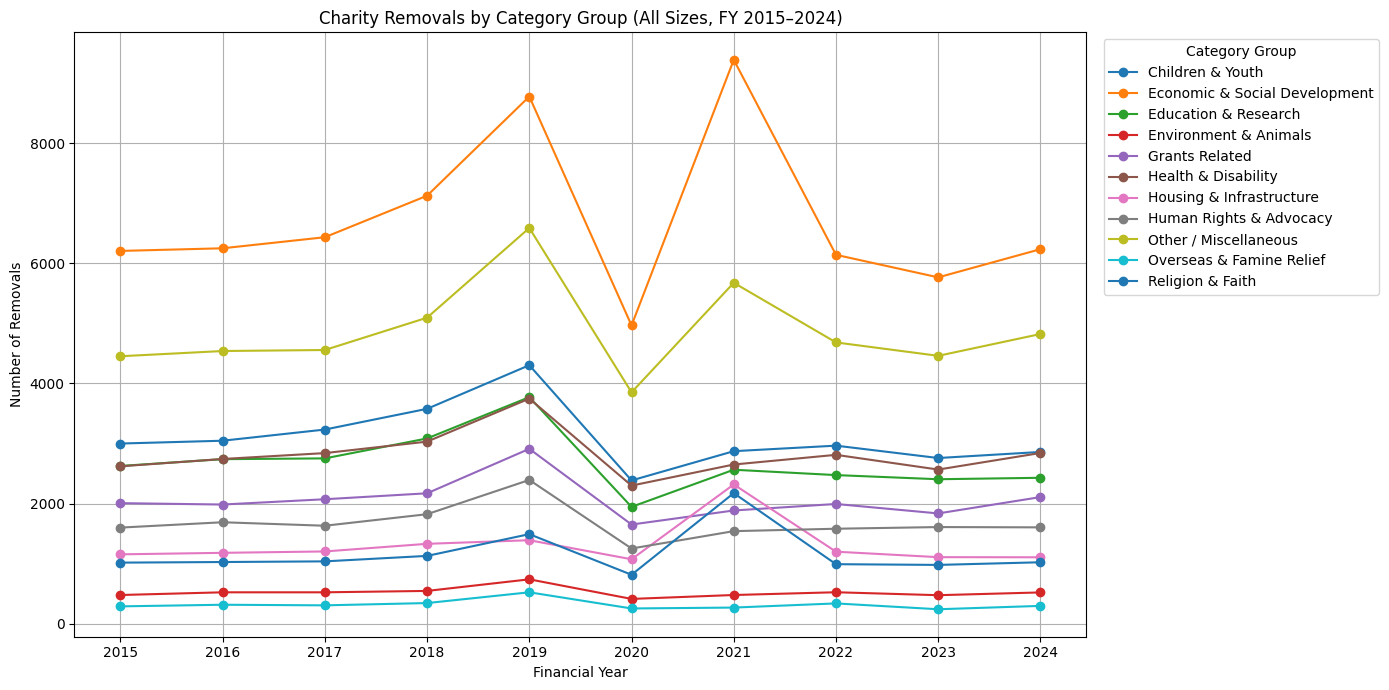

In [16]:
# --- Step 1: Define dummy-to-group mapping ---
category_map = {
    'classification_makes_grants_to_individuals': 'Grants Related',
    'classification_makes_grants_to_organisations': 'Grants Related',
    'classification_accommodation/housing': 'Housing & Infrastructure',
    'classification_provides_buildings/facilities/open_space': 'Housing & Infrastructure',
    'classification_education/training': 'Education & Research',
    'classification_sponsors_or_undertakes_research': 'Education & Research',
    'classification_children/young_people': 'Children & Youth',
    'classification_amateur_sport': 'Children & Youth',
    'classification_the_advancement_of_health_or_saving_of_lives': 'Health & Disability',
    'classification_disability': 'Health & Disability',
    'classification_people_with_disabilities': 'Health & Disability',
    'classification_human_rights/religious_or_racial_harmony/equality_or_diversity': 'Human Rights & Advocacy',
    'classification_provides_advocacy/advice/information': 'Human Rights & Advocacy',
    'classification_people_of_a_particular_ethnic_or_racial_origin': 'Human Rights & Advocacy',
    'classification_religious_activities': 'Religion & Faith',
    'classification_acts_as_an_umbrella_or_resource_body': 'Religion & Faith',
    'classification_environment/conservation/heritage': 'Environment & Animals',
    'classification_animals': 'Environment & Animals',
    'classification_economic/community_development/employment': 'Economic & Social Development',
    'classification_general_charitable_purposes': 'Economic & Social Development',
    'classification_provides_services': 'Economic & Social Development',
    'classification_provides_human_resources': 'Economic & Social Development',
    'classification_provides_other_finance': 'Economic & Social Development',
    'classification_other_charitable_purposes': 'Economic & Social Development',
    'classification_other_charities_or_voluntary_bodies': 'Economic & Social Development',
    'classification_overseas_aid/famine_relief': 'Overseas & Famine Relief',
    'classification_the_general_public/mankind': 'Other / Miscellaneous',
    'classification_other_defined_groups': 'Other / Miscellaneous',
    'classification_recreation': 'Other / Miscellaneous',
    'classification_elderly/old_people': 'Other / Miscellaneous',
    'classification_armed_forces/emergency_service_efficiency': 'Other / Miscellaneous',
    'classification_arts/culture/heritage/science': 'Other / Miscellaneous',
}

# --- Step 2: Get category groups ---
dummy_to_group = {col: group for col, group in category_map.items()}
all_groups = sorted(set(dummy_to_group.values()))

# --- Step 3: Filter relevant years ---
filtered = dataset[dataset['removal_fy'].between(2015, 2024)].copy()

# --- Step 4: Build summary across all sizes ---
summary = pd.DataFrame(index=range(2015, 2025))

for group in all_groups:
    matching_cols = [col for col, g in dummy_to_group.items() if g == group and col in filtered.columns]
    if matching_cols:
        counts = (
            filtered
            .groupby('removal_fy')[matching_cols]
            .sum()
            .sum(axis=1)
            .reindex(summary.index, fill_value=0)
        )
    else:
        counts = pd.Series(0, index=summary.index)
    summary[group] = counts

# --- Step 5: Plot ---
plt.figure(figsize=(14, 7))
for col in summary.columns:
    plt.plot(summary.index, summary[col], marker='o', label=col)

plt.title("Charity Removals by Category Group (All Sizes, FY 2015–2024)")
plt.xlabel("Financial Year")
plt.ylabel("Number of Removals")
plt.grid(True)
plt.legend(title="Category Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.xticks(summary.index)
plt.show()


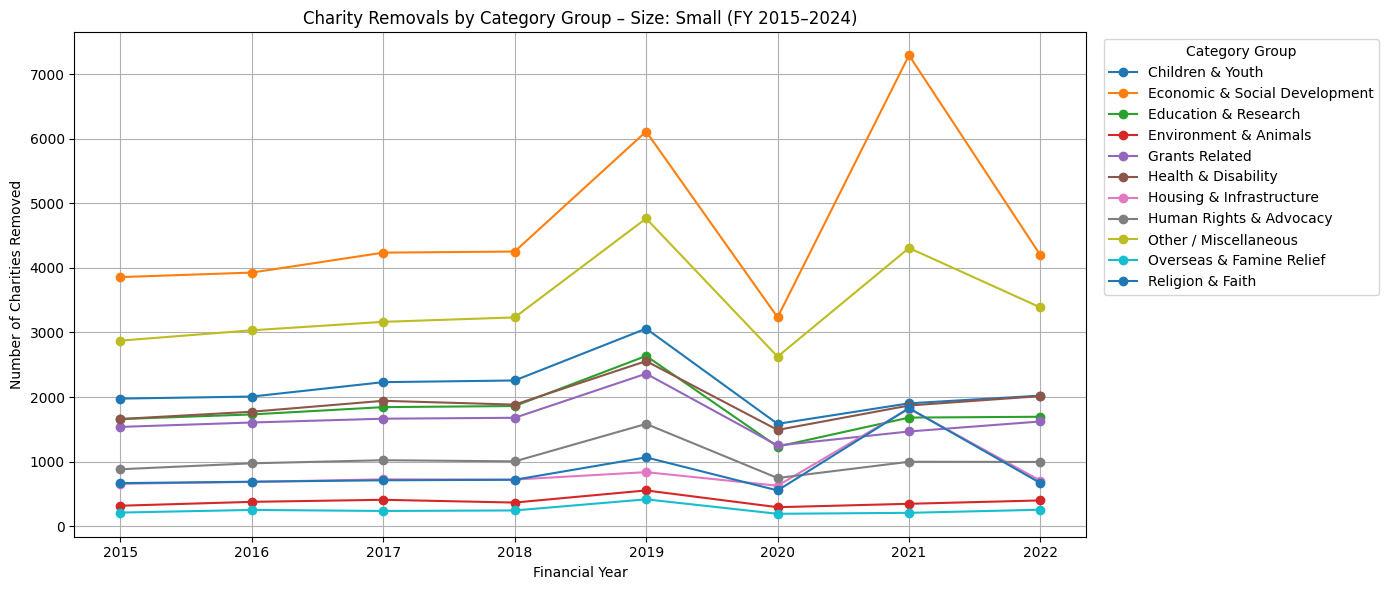

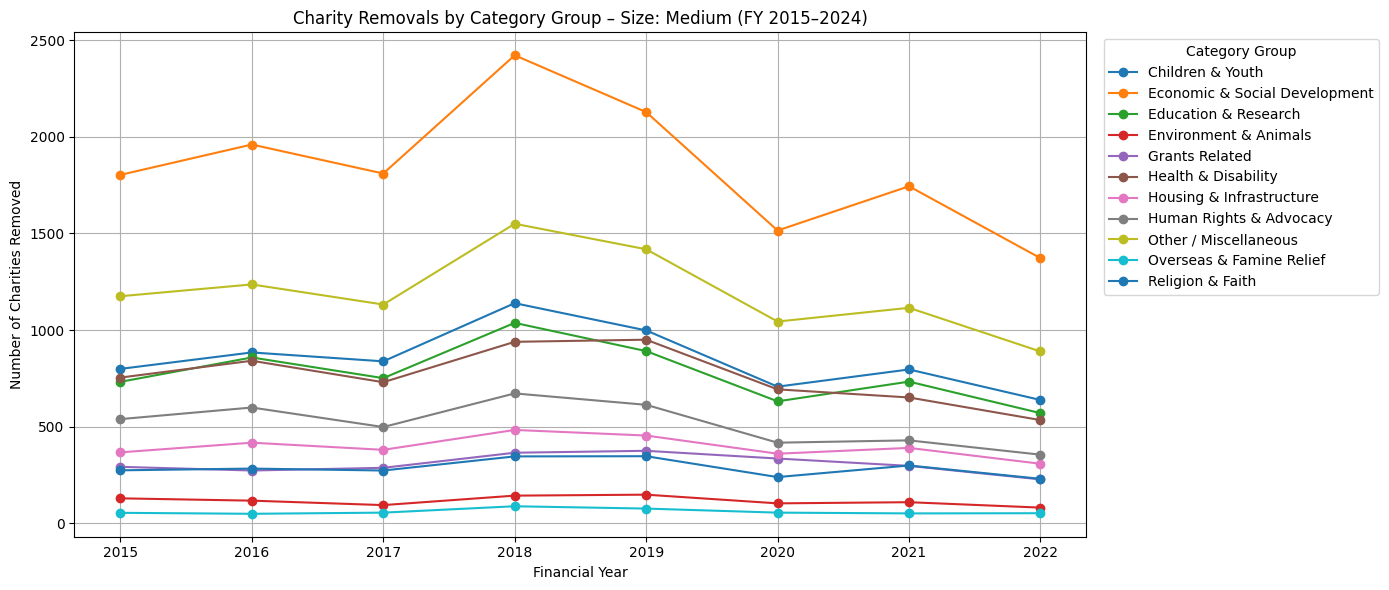

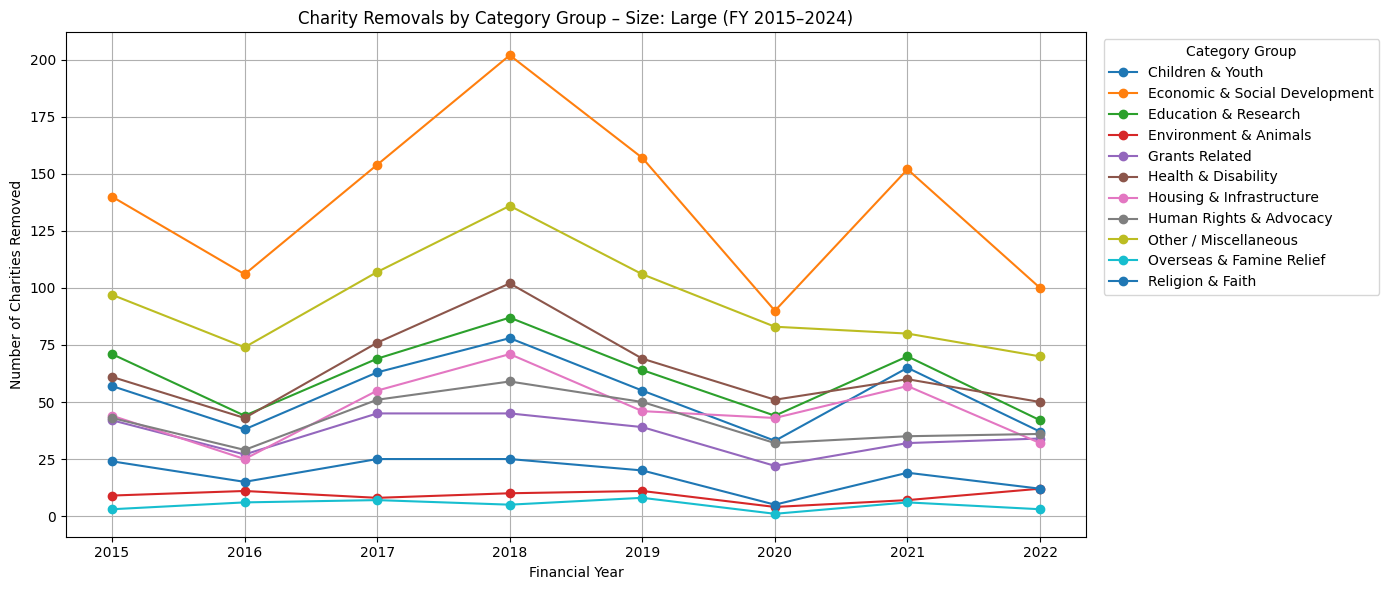

In [19]:
# --- Step 1: Define category grouping ---
category_map = {
    'classification_makes_grants_to_individuals': 'Grants Related',
    'classification_makes_grants_to_organisations': 'Grants Related',
    'classification_accommodation/housing': 'Housing & Infrastructure',
    'classification_provides_buildings/facilities/open_space': 'Housing & Infrastructure',
    'classification_education/training': 'Education & Research',
    'classification_sponsors_or_undertakes_research': 'Education & Research',
    'classification_children/young_people': 'Children & Youth',
    'classification_amateur_sport': 'Children & Youth',
    'classification_the_advancement_of_health_or_saving_of_lives': 'Health & Disability',
    'classification_disability': 'Health & Disability',
    'classification_people_with_disabilities': 'Health & Disability',
    'classification_human_rights/religious_or_racial_harmony/equality_or_diversity': 'Human Rights & Advocacy',
    'classification_provides_advocacy/advice/information': 'Human Rights & Advocacy',
    'classification_people_of_a_particular_ethnic_or_racial_origin': 'Human Rights & Advocacy',
    'classification_religious_activities': 'Religion & Faith',
    'classification_acts_as_an_umbrella_or_resource_body': 'Religion & Faith',
    'classification_environment/conservation/heritage': 'Environment & Animals',
    'classification_animals': 'Environment & Animals',
    'classification_economic/community_development/employment': 'Economic & Social Development',
    'classification_general_charitable_purposes': 'Economic & Social Development',
    'classification_provides_services': 'Economic & Social Development',
    'classification_provides_human_resources': 'Economic & Social Development',
    'classification_provides_other_finance': 'Economic & Social Development',
    'classification_other_charitable_purposes': 'Economic & Social Development',
    'classification_other_charities_or_voluntary_bodies': 'Economic & Social Development',
    'classification_overseas_aid/famine_relief': 'Overseas & Famine Relief',
    'classification_the_general_public/mankind': 'Other / Miscellaneous',
    'classification_other_defined_groups': 'Other / Miscellaneous',
    'classification_recreation': 'Other / Miscellaneous',
    'classification_elderly/old_people': 'Other / Miscellaneous',
    'classification_armed_forces/emergency_service_efficiency': 'Other / Miscellaneous',
    'classification_arts/culture/heritage/science': 'Other / Miscellaneous',
}

# --- Step 2: Reverse map dummy columns to group names ---
dummy_to_group = {col: group for col, group in category_map.items()}
all_groups = sorted(set(dummy_to_group.values()))

# --- Step 3: Plot removal counts by financial year, split by size ---
for size in ['Small', 'Medium', 'Large']:
    subset = dataset[
        (dataset['size_category'] == size) &
        (dataset['removal_fy'].between(2015, 2022))
    ].copy()

    summary = pd.DataFrame(index=range(2015, 2023))  # FYs 2015–2024

    for group in all_groups:
        matching_cols = [col for col, g in dummy_to_group.items() if g == group and col in subset.columns]
        if matching_cols:
            counts = (
                subset
                .groupby('removal_fy')[matching_cols]
                .sum()
                .sum(axis=1)
                .reindex(summary.index, fill_value=0)
            )
        else:
            counts = pd.Series(0, index=summary.index)

        summary[group] = counts

    # --- Plot ---
    plt.figure(figsize=(14, 6))
    for col in summary.columns:
        plt.plot(summary.index, summary[col], marker='o', label=col)

    plt.title(f"Charity Removals by Category Group – Size: {size} (FY 2015–2024)")
    plt.xlabel("Financial Year")
    plt.ylabel("Number of Charities Removed")
    plt.legend(title='Category Group', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(summary.index)
    plt.show()


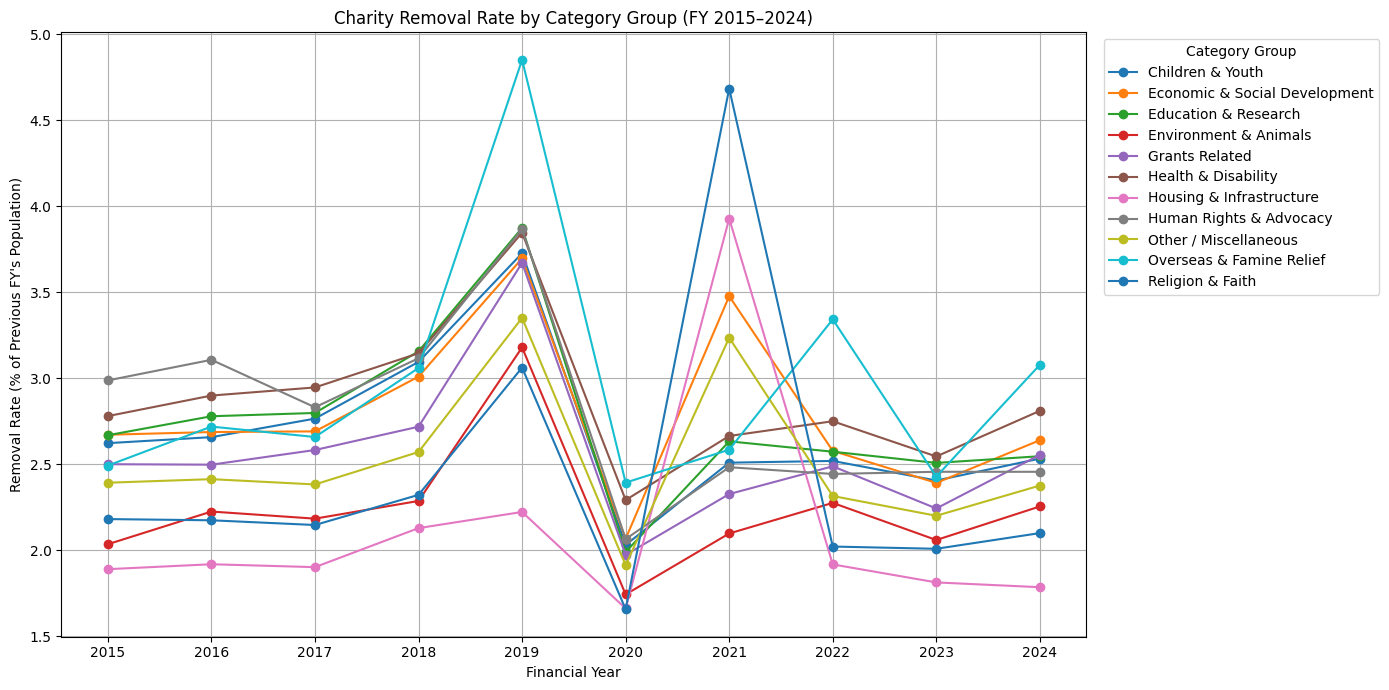

In [17]:
# --- Step 1: Define dummy-to-group mapping ---
category_map = {
    'classification_makes_grants_to_individuals': 'Grants Related',
    'classification_makes_grants_to_organisations': 'Grants Related',
    'classification_accommodation/housing': 'Housing & Infrastructure',
    'classification_provides_buildings/facilities/open_space': 'Housing & Infrastructure',
    'classification_education/training': 'Education & Research',
    'classification_sponsors_or_undertakes_research': 'Education & Research',
    'classification_children/young_people': 'Children & Youth',
    'classification_amateur_sport': 'Children & Youth',
    'classification_the_advancement_of_health_or_saving_of_lives': 'Health & Disability',
    'classification_disability': 'Health & Disability',
    'classification_people_with_disabilities': 'Health & Disability',
    'classification_human_rights/religious_or_racial_harmony/equality_or_diversity': 'Human Rights & Advocacy',
    'classification_provides_advocacy/advice/information': 'Human Rights & Advocacy',
    'classification_people_of_a_particular_ethnic_or_racial_origin': 'Human Rights & Advocacy',
    'classification_religious_activities': 'Religion & Faith',
    'classification_acts_as_an_umbrella_or_resource_body': 'Religion & Faith',
    'classification_environment/conservation/heritage': 'Environment & Animals',
    'classification_animals': 'Environment & Animals',
    'classification_economic/community_development/employment': 'Economic & Social Development',
    'classification_general_charitable_purposes': 'Economic & Social Development',
    'classification_provides_services': 'Economic & Social Development',
    'classification_provides_human_resources': 'Economic & Social Development',
    'classification_provides_other_finance': 'Economic & Social Development',
    'classification_other_charitable_purposes': 'Economic & Social Development',
    'classification_other_charities_or_voluntary_bodies': 'Economic & Social Development',
    'classification_overseas_aid/famine_relief': 'Overseas & Famine Relief',
    'classification_the_general_public/mankind': 'Other / Miscellaneous',
    'classification_other_defined_groups': 'Other / Miscellaneous',
    'classification_recreation': 'Other / Miscellaneous',
    'classification_elderly/old_people': 'Other / Miscellaneous',
    'classification_armed_forces/emergency_service_efficiency': 'Other / Miscellaneous',
    'classification_arts/culture/heritage/science': 'Other / Miscellaneous',
}

dummy_to_group = {col: group for col, group in category_map.items()}
all_groups = sorted(set(dummy_to_group.values()))
years = list(range(2015, 2025))

# --- Step 2: Preprocess ---
for col in dummy_to_group:
    if col in dataset.columns:
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce').fillna(0).astype(int)

dataset['registration_fy'] = pd.to_numeric(dataset['registration_fy'], errors='coerce')
dataset['removal_fy'] = pd.to_numeric(dataset['removal_fy'], errors='coerce')

# --- Step 3: Compute category population at start of each FY ---
population_summary = {group: [] for group in all_groups}

for fy in years:
    # Define active charities at the start of FY fy
    active = dataset[
        (dataset['registration_fy'] <= fy) &
        ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy))
    ]

    # Compute group-wise counts
    for group in all_groups:
        # Columns for this group
        cols = [col for col, g in dummy_to_group.items() if g == group and col in active.columns]
        
        # Count unique charity rows where at least one column in this group = 1
        if cols:
            group_count = active[cols].eq(1).any(axis=1).sum()
        else:
            group_count = 0

        population_summary[group].append(group_count)

population_df = pd.DataFrame(population_summary, index=years)

# --- Step 4: Compute number of removals per group per FY ---
removal_summary = {group: [] for group in all_groups}
removed_all = dataset[dataset['removal_fy'].between(2015, 2024)]

for fy in years:
    removed = removed_all[removed_all['removal_fy'] == fy]
    for group in all_groups:
        cols = [col for col, g in dummy_to_group.items() if g == group and col in removed.columns]
        count = removed[cols].eq(1).any(axis=1).sum() if cols else 0
        removal_summary[group].append(count)

removals_df = pd.DataFrame(removal_summary, index=years)

# --- Step 5: Calculate removal rate per category group ---
rate_df = (removals_df / population_df.replace(0, pd.NA)) * 100

# --- Step 6: Plot ---
plt.figure(figsize=(14, 7))
for col in rate_df.columns:
    plt.plot(rate_df.index, rate_df[col], marker='o', label=col)

plt.title("Charity Removal Rate by Category Group (FY 2015–2024)")
plt.xlabel("Financial Year")
plt.ylabel("Removal Rate (% of Previous FY's Population)")
plt.grid(True)
plt.legend(title="Category Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rate_df.index)
plt.show()


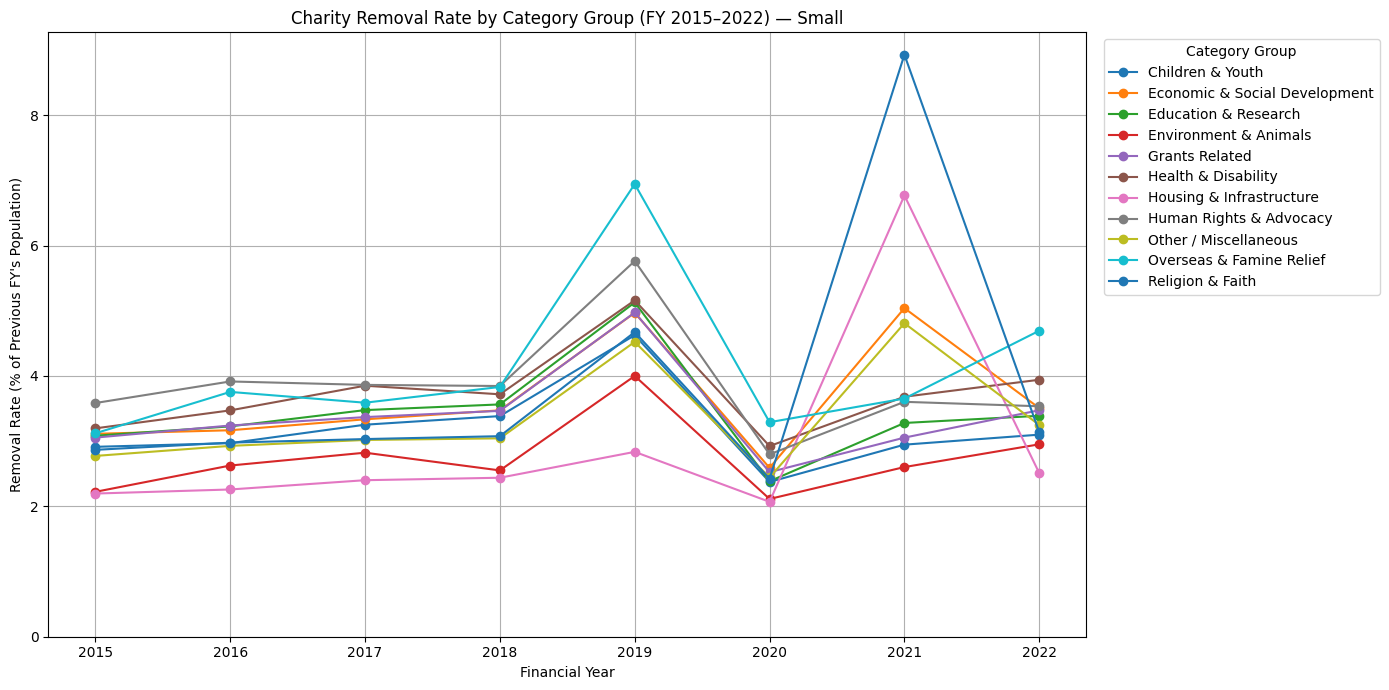

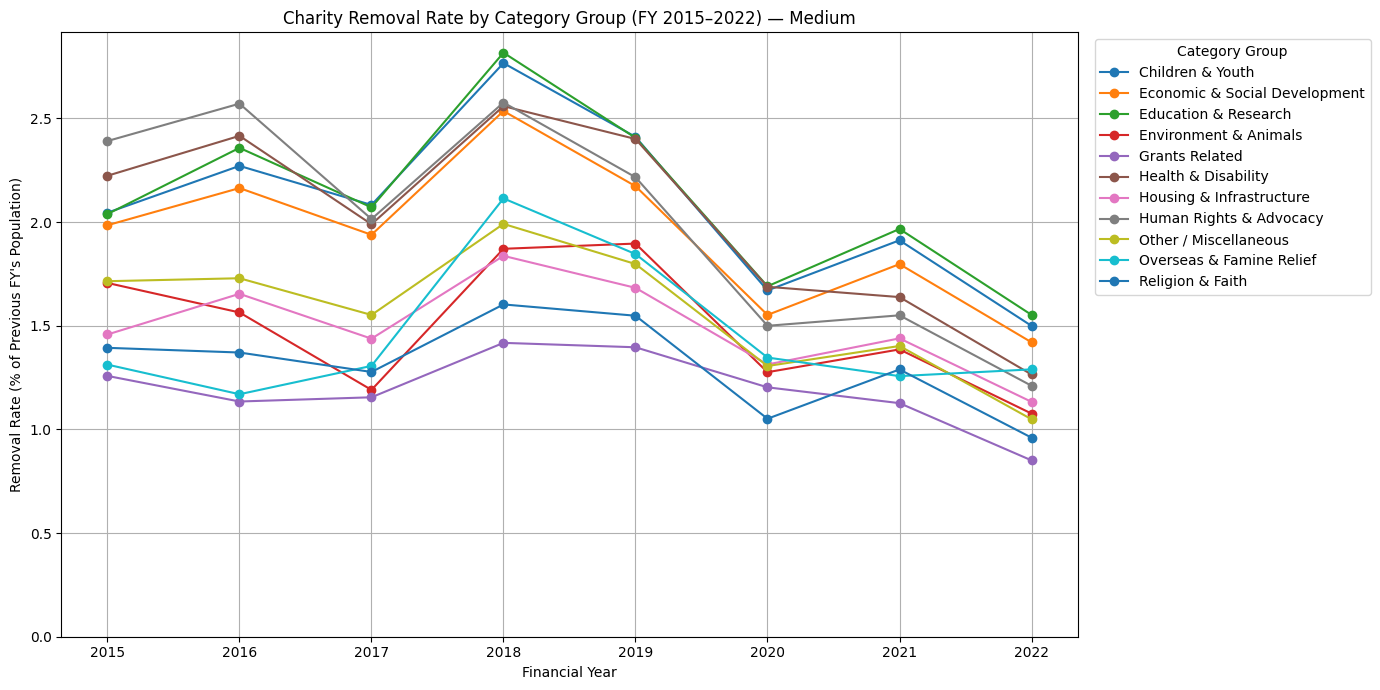

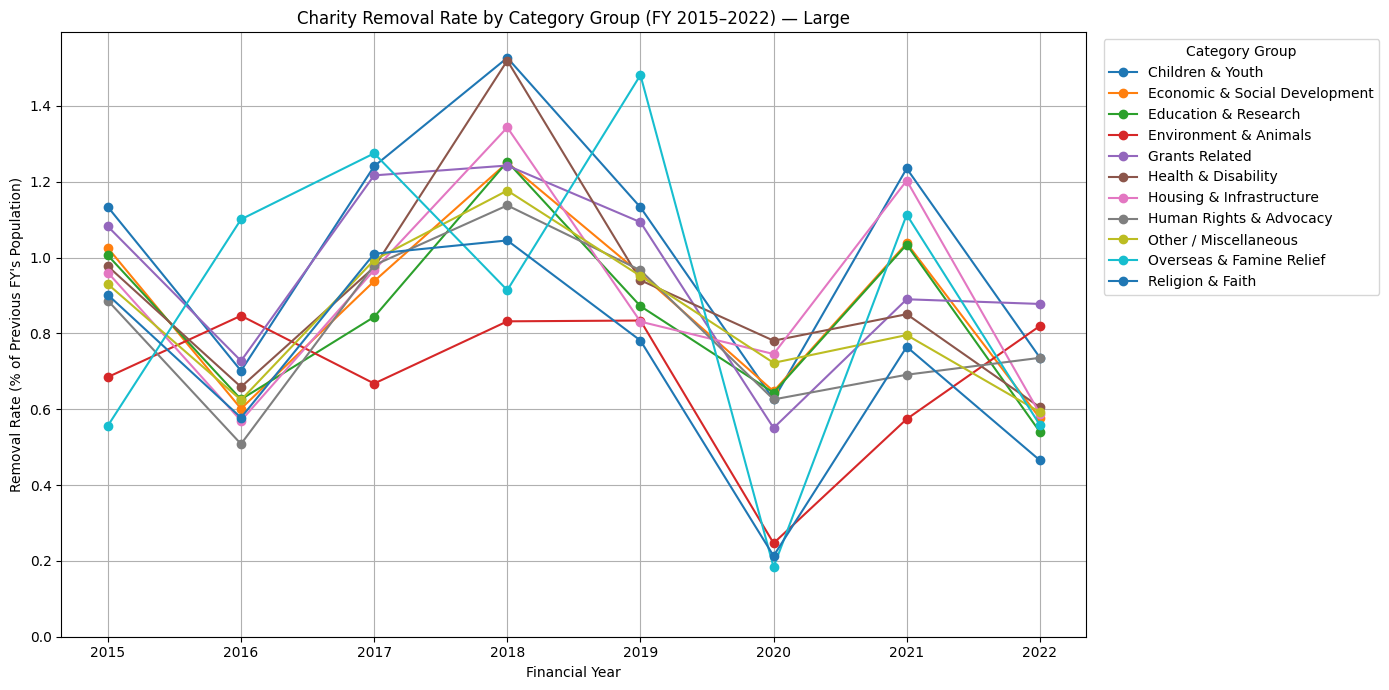

In [27]:
# --- Step 1: Define dummy-to-group mapping ---
category_map = {
    'classification_makes_grants_to_individuals': 'Grants Related',
    'classification_makes_grants_to_organisations': 'Grants Related',
    'classification_accommodation/housing': 'Housing & Infrastructure',
    'classification_provides_buildings/facilities/open_space': 'Housing & Infrastructure',
    'classification_education/training': 'Education & Research',
    'classification_sponsors_or_undertakes_research': 'Education & Research',
    'classification_children/young_people': 'Children & Youth',
    'classification_amateur_sport': 'Children & Youth',
    'classification_the_advancement_of_health_or_saving_of_lives': 'Health & Disability',
    'classification_disability': 'Health & Disability',
    'classification_people_with_disabilities': 'Health & Disability',
    'classification_human_rights/religious_or_racial_harmony/equality_or_diversity': 'Human Rights & Advocacy',
    'classification_provides_advocacy/advice/information': 'Human Rights & Advocacy',
    'classification_people_of_a_particular_ethnic_or_racial_origin': 'Human Rights & Advocacy',
    'classification_religious_activities': 'Religion & Faith',
    'classification_acts_as_an_umbrella_or_resource_body': 'Religion & Faith',
    'classification_environment/conservation/heritage': 'Environment & Animals',
    'classification_animals': 'Environment & Animals',
    'classification_economic/community_development/employment': 'Economic & Social Development',
    'classification_general_charitable_purposes': 'Economic & Social Development',
    'classification_provides_services': 'Economic & Social Development',
    'classification_provides_human_resources': 'Economic & Social Development',
    'classification_provides_other_finance': 'Economic & Social Development',
    'classification_other_charitable_purposes': 'Economic & Social Development',
    'classification_other_charities_or_voluntary_bodies': 'Economic & Social Development',
    'classification_overseas_aid/famine_relief': 'Overseas & Famine Relief',
    'classification_the_general_public/mankind': 'Other / Miscellaneous',
    'classification_other_defined_groups': 'Other / Miscellaneous',
    'classification_recreation': 'Other / Miscellaneous',
    'classification_elderly/old_people': 'Other / Miscellaneous',
    'classification_armed_forces/emergency_service_efficiency': 'Other / Miscellaneous',
    'classification_arts/culture/heritage/science': 'Other / Miscellaneous',
}

dummy_to_group = {col: group for col, group in category_map.items()}
all_groups = sorted(set(dummy_to_group.values()))
years = list(range(2015, 2023))

# --- Step 2: Preprocess dummy columns and date columns ---
for col in dummy_to_group:
    if col in dataset.columns:
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce').fillna(0).astype(int)

dataset['registration_fy'] = pd.to_numeric(dataset['registration_fy'], errors='coerce')
dataset['removal_fy'] = pd.to_numeric(dataset['removal_fy'], errors='coerce')

# --- Step 3–6: Loop over each size category ---
for size in ['Small', 'Medium', 'Large']:
    subset = dataset[dataset['size_category'].str.strip().str.title() == size]

    # Step 3: Compute active population per category per FY
    population_summary = {group: [] for group in all_groups}
    for fy in years:
        active = subset[
            (subset['registration_fy'] <= fy) &
            ((subset['removal_fy'].isna()) | (subset['removal_fy'] > fy))
        ]
        for group in all_groups:
            cols = [col for col, g in dummy_to_group.items() if g == group and col in active.columns]
            group_count = active[cols].eq(1).any(axis=1).sum() if cols else 0
            population_summary[group].append(group_count)
    population_df = pd.DataFrame(population_summary, index=years)

    # Step 4: Count removals per group per FY
    removal_summary = {group: [] for group in all_groups}
    removed_all = subset[subset['removal_fy'].between(2015, 2022)]
    for fy in years:
        removed = removed_all[removed_all['removal_fy'] == fy]
        for group in all_groups:
            cols = [col for col, g in dummy_to_group.items() if g == group and col in removed.columns]
            count = removed[cols].eq(1).any(axis=1).sum() if cols else 0
            removal_summary[group].append(count)
    removals_df = pd.DataFrame(removal_summary, index=years)

    # Step 5: Calculate removal rate
    rate_df = (removals_df / population_df.replace(0, pd.NA)) * 100

    # Step 6: Plot
    plt.figure(figsize=(14, 7))
    for col in rate_df.columns:
        plt.plot(rate_df.index, rate_df[col], marker='o', label=col)

    plt.title(f"Charity Removal Rate by Category Group (FY 2015–2022) — {size}")
    plt.xlabel("Financial Year")
    plt.ylabel("Removal Rate (% of Previous FY's Population)")
    plt.grid(True)
    plt.legend(title="Category Group", bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.xticks(rate_df.index)
    plt.ylim(bottom=0)
    plt.show()


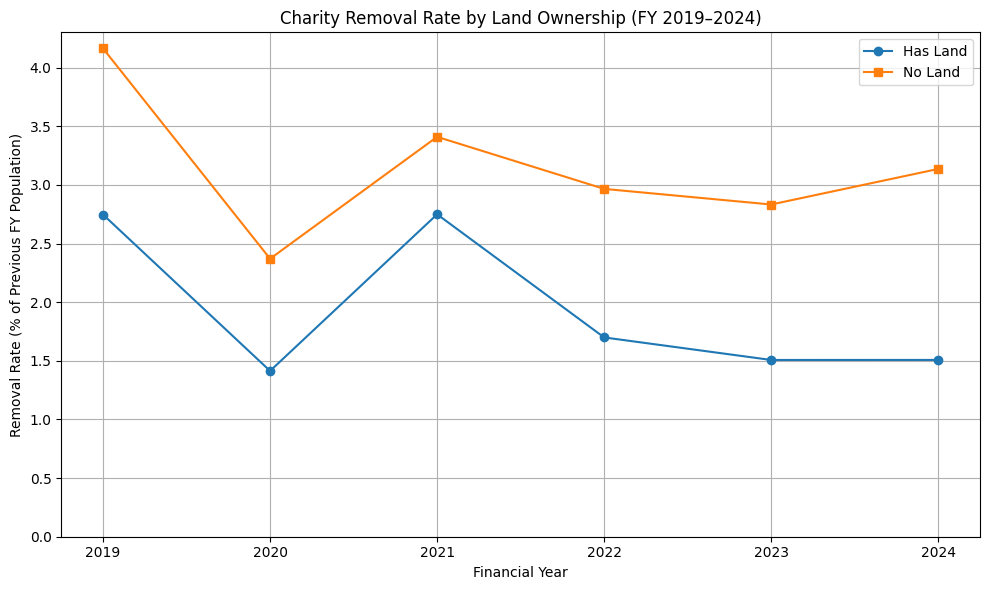

In [30]:
# Ensure boolean column
dataset['charity_has_land'] = dataset['charity_has_land'].astype(bool)

# Define financial years
years = list(range(2019, 2025))

# Prepare dicts to hold results
removal_rates_with_land = []
removal_rates_without_land = []

for fy in years:
    # Define active population in the year before (for denominator)
    active_with_land = dataset[
        (dataset['charity_has_land'] == True) &
        (dataset['registration_fy'] <= fy - 1) &
        ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
    ]
    active_without_land = dataset[
        (dataset['charity_has_land'] == False) &
        (dataset['registration_fy'] <= fy - 1) &
        ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
    ]

    # Define removals in the current year (for numerator)
    removed_with_land = dataset[
        (dataset['charity_has_land'] == True) &
        (dataset['removal_fy'] == fy)
    ]
    removed_without_land = dataset[
        (dataset['charity_has_land'] == False) &
        (dataset['removal_fy'] == fy)
    ]

    # Compute rates
    rate_with_land = (len(removed_with_land) / len(active_with_land)) * 100 if len(active_with_land) > 0 else float('nan')
    rate_without_land = (len(removed_without_land) / len(active_without_land)) * 100 if len(active_without_land) > 0 else float('nan')

    # Append to lists
    removal_rates_with_land.append(rate_with_land)
    removal_rates_without_land.append(rate_without_land)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(years, removal_rates_with_land, marker='o', label='Has Land')
plt.plot(years, removal_rates_without_land, marker='s', label='No Land')

plt.title('Charity Removal Rate by Land Ownership (FY 2019–2024)')
plt.xlabel('Financial Year')
plt.ylabel('Removal Rate (% of Previous FY Population)')
plt.legend()
plt.grid(True)
plt.xticks(years)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


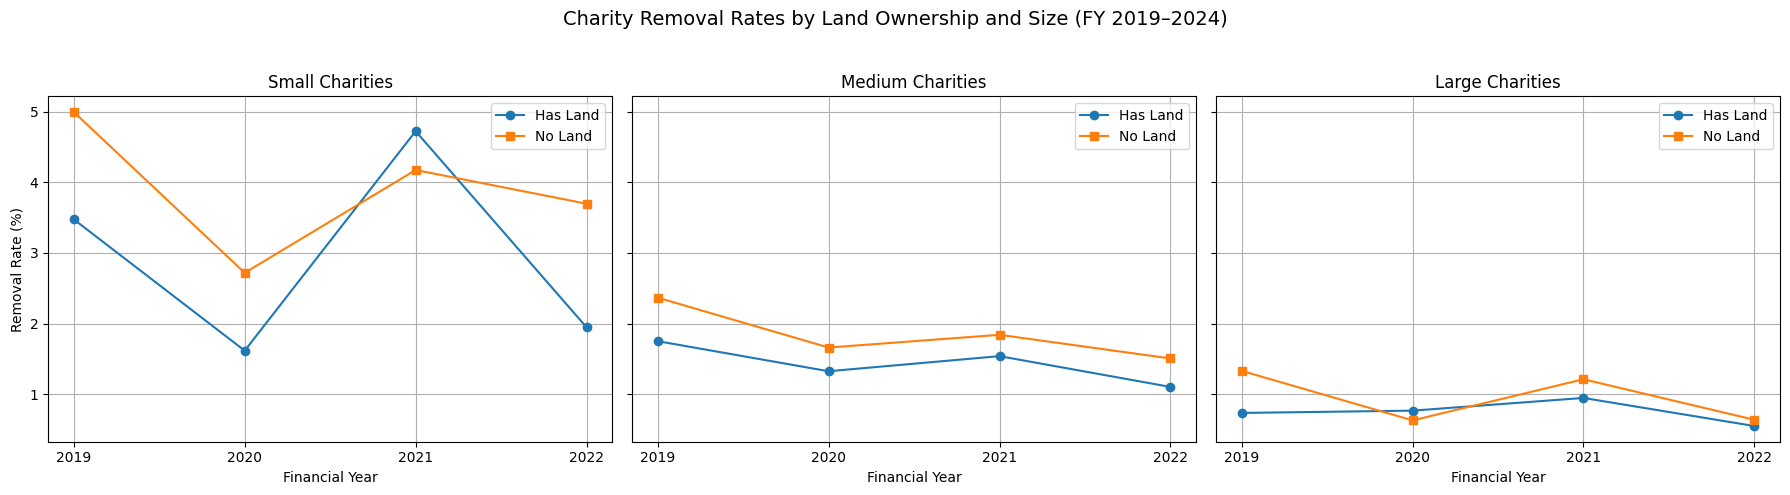

In [32]:
# Ensure boolean and categorical formatting
dataset['charity_has_land'] = dataset['charity_has_land'].astype(bool)
dataset['size_category'] = dataset['size_category'].str.strip().str.title()

# Define financial years and size categories
years = list(range(2019, 2023))
sizes = ['Small', 'Medium', 'Large']

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, size in enumerate(sizes):
    removal_rates_with_land = []
    removal_rates_without_land = []

    for fy in years:
        # Define active charities in previous FY
        active_with_land = dataset[
            (dataset['charity_has_land'] == True) &
            (dataset['size_category'] == size) &
            (dataset['registration_fy'] <= fy - 1) &
            ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
        ]
        active_without_land = dataset[
            (dataset['charity_has_land'] == False) &
            (dataset['size_category'] == size) &
            (dataset['registration_fy'] <= fy - 1) &
            ((dataset['removal_fy'].isna()) | (dataset['removal_fy'] > fy - 1))
        ]

        # Define removals in current FY
        removed_with_land = dataset[
            (dataset['charity_has_land'] == True) &
            (dataset['size_category'] == size) &
            (dataset['removal_fy'] == fy)
        ]
        removed_without_land = dataset[
            (dataset['charity_has_land'] == False) &
            (dataset['size_category'] == size) &
            (dataset['removal_fy'] == fy)
        ]

        # Calculate rates
        rate_with_land = (len(removed_with_land) / len(active_with_land)) * 100 if len(active_with_land) > 0 else float('nan')
        rate_without_land = (len(removed_without_land) / len(active_without_land)) * 100 if len(active_without_land) > 0 else float('nan')

        removal_rates_with_land.append(rate_with_land)
        removal_rates_without_land.append(rate_without_land)

    # Plot for current size
    ax = axes[i]
    ax.plot(years, removal_rates_with_land, marker='o', label='Has Land')
    ax.plot(years, removal_rates_without_land, marker='s', label='No Land')
    ax.set_title(f'{size} Charities')
    ax.set_xlabel('Financial Year')
    if i == 0:
        ax.set_ylabel('Removal Rate (%)')
    ax.set_xticks(years)
    ax.grid(True)
    ax.legend()

plt.suptitle('Charity Removal Rates by Land Ownership and Size (FY 2019–2024)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
